In [ ]:
# Parameters (papermill)
from pathlib import Path

RAW_DIR = "data/raw"          # sobreescrito por papermill si usas --parameters
PROCESSED_DIR = "data/processed"
RANDOM_STATE = 42

RAW_DIR = Path(RAW_DIR)
PROCESSED_DIR = Path(PROCESSED_DIR)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

#  MODELO SUPERVISADO

C:\Users\alons\AppData\Local\Temp\ipykernel_20736\4092342914.py:16: DtypeWarning: Columns (1,2,3,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta)


Distribución de clases:
Etiqueta_Binaria
0    841115
1      4201
Name: count, dtype: int64
=== MATRIZ DE CONFUSIÓN ===
[[9953    0]
 [   1   46]]

=== REPORTE DE CLASIFICACIÓN ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9953
           1       1.00      0.98      0.99        47

    accuracy                           1.00     10000
   macro avg       1.00      0.99      0.99     10000
weighted avg       1.00      1.00      1.00     10000

AUC: 0.9999978622932035


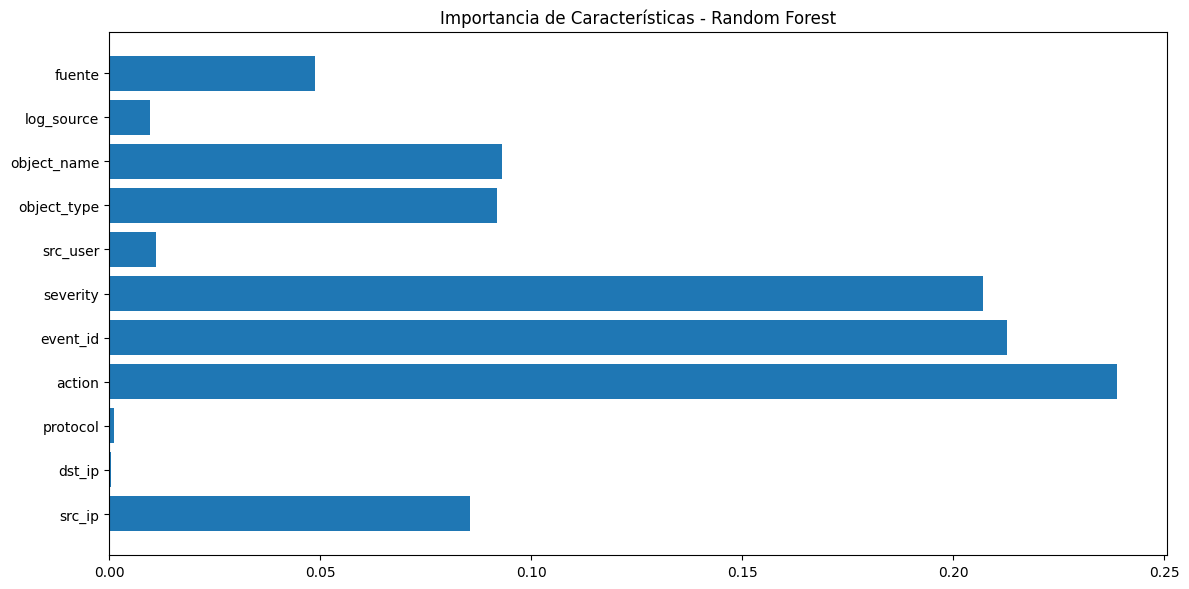

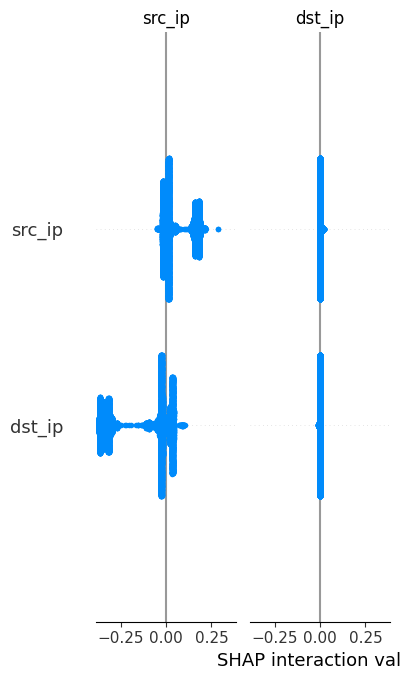

In [ ]:
# LIBRERÍAS
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import shap
import os

# CARGA DE DATOS
ruta = "/Users/alonso/Downloads/Tesis_SIEM_ML/data/processed_logs/logs_normalizados.csv"
df = pd.read_csv(ruta)

# Generar columna Etiqueta_Binaria con lógica ampliada
palabras_clave_maliciosas = ['modificación', 'malicioso', 'bloqueado', 'rechazado', 'ataque', 'cifrado']
df['Etiqueta_Binaria'] = df['description'].apply(
    lambda x: 1 if isinstance(x, str) and any(p in x.lower() for p in palabras_clave_maliciosas) else 0
)
print("Distribución de clases:")
print(df['Etiqueta_Binaria'].value_counts())

# MUESTRA DEL DATASET PARA PRUEBA RÁPIDA
df = df.sample(n=50000, random_state=42)  # usar solo 50k filas para agilizar
columnas_excluir = ['timestamp', 'description']
X = df.drop(columns=columnas_excluir + ['Etiqueta_Binaria'])
y = df['Etiqueta_Binaria']

# LIMPIEZA Y CODIFICACIÓN
X = X.fillna("desconocido")
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

# DIVISIÓN Y BALANCEO
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# ESCALADO
scaler = StandardScaler()
X_train_bal = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

# RANDOM FOREST OPTIMIZADO
param_grid = {
    "n_estimators": [100],
    "max_depth": [None],
    "min_samples_split": [2]
}
rf = RandomForestClassifier(random_state=42)
clf = GridSearchCV(rf, param_grid, cv=3, scoring='f1', n_jobs=-1)
clf.fit(X_train_bal, y_train_bal)

# EVALUACIÓN
y_pred = clf.predict(X_test_scaled)
print("=== MATRIZ DE CONFUSIÓN ===")
print(confusion_matrix(y_test, y_pred))
print("\n=== REPORTE DE CLASIFICACIÓN ===")
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, clf.predict_proba(X_test_scaled)[:,1]))

# GUARDADO
os.makedirs("/Users/alonso/Downloads/Tesis_SIEM_ML/modelos", exist_ok=True)
joblib.dump(clf.best_estimator_, "/Users/alonso/Downloads/Tesis_SIEM_ML/modelos/rf_model_clasificacion.pkl")
joblib.dump(scaler, "/Users/alonso/Downloads/Tesis_SIEM_ML/modelos/rf_scaler.pkl")

# IMPORTANCIA DE CARACTERÍSTICAS
importancias = clf.best_estimator_.feature_importances_
features = X.columns
plt.figure(figsize=(12, 6))
plt.barh(features, importancias)
plt.title("Importancia de Características - Random Forest")
plt.tight_layout()
plt.show()

# Modelo No Supervisado (Isolation Forest)

In [ ]:
# LIBRERÍAS
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, LabelEncoder

# CARGA DE DATOS
ruta = "/Users/alonso/Downloads/Tesis_SIEM_ML/data/processed_logs/logs_normalizados.csv"
df = pd.read_csv(ruta)

# PREPROCESAMIENTO
columnas_excluir = ['timestamp', 'description']
X = df.drop(columns=columnas_excluir, errors='ignore')
X = X.fillna("desconocido")

# Codificación de variables categóricas (sin expansión de columnas)
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ENTRENAMIENTO DEL MODELO
modelo_isf = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    contamination=0.01,  # asume 1% de eventos anómalos
    random_state=42,
    verbose=1
)
modelo_isf.fit(X_scaled)

# PREDICCIÓN
df['Anomalia_IF'] = modelo_isf.predict(X_scaled)
df['Anomalia_IF'] = df['Anomalia_IF'].map({1: 0, -1: 1})  # 0 = normal, 1 = anómalo

# GUARDADO DEL MODELO Y ESCALADOR
os.makedirs("/Users/alonso/Downloads/Tesis_SIEM_ML/modelos", exist_ok=True)
joblib.dump(modelo_isf, "/Users/alonso/Downloads/Tesis_SIEM_ML/modelos/isolation_forest_model.pkl")
joblib.dump(scaler, "/Users/alonso/Downloads/Tesis_SIEM_ML/modelos/isolation_forest_scaler.pkl")

# GUARDADO DE RESULTADOS
ruta_salida = "/Users/alonso/Downloads/Tesis_SIEM_ML/data/processed_logs/logs_con_anomalias.csv"
df.to_csv(ruta_salida, index=False)

# INFORME RESUMIDO
print(f"Total de eventos analizados: {len(df)}")
print(f"Eventos anómalos detectados: {df['Anomalia_IF'].sum()}")
print(f"Porcentaje: {round(100 * df['Anomalia_IF'].mean(), 2)} %")
print(f"Archivo generado: {ruta_salida}")

C:\Users\alons\AppData\Local\Temp\ipykernel_20736\1099661013.py:11: DtypeWarning: Columns (1,2,3,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished


Total de eventos analizados: 845316
Eventos anómalos detectados: 6923
Porcentaje: 0.82 %
Archivo generado: C:/Users/alons/Desktop/Tesis_SIEM_ML/data/processed_logs/logs_con_anomalias.csv


# Modelo Híbrido: Random Forest + Isolation Forest

In [ ]:
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder

# Carga tu dataset original (con datos categóricos sin codificar)
df = pd.read_csv("/Users/alonso/Downloads/Tesis_SIEM_ML/data/processed_logs/logs_normalizados.csv")

# Define las columnas de entrada categóricas (las mismas usadas en entrenamiento del modelo)
columnas_entrada = [
    'src_ip', 'dst_ip', 'protocol', 'action', 'description',
    'event_id', 'severity', 'src_user', 'object_type', 'object_name', 'log_source'
]

# Diccionario para guardar los LabelEncoders
encoders = {}

# Aplicar LabelEncoder a cada columna categórica
for col in columnas_entrada:
    le = LabelEncoder()
    df[col] = df[col].astype(str).fillna("desconocido")
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

# Guardar los encoders
joblib.dump(encoders, "/Users/alonso/Downloads/Tesis_SIEM_ML/modelos/label_encoders.pkl")

print(" Encoders entrenados y guardados correctamente.")

C:\Users\alons\AppData\Local\Temp\ipykernel_20736\3995647261.py:6: DtypeWarning: Columns (1,2,3,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:/Users/alons/Desktop/Tesis_SIEM_ML/data/processed_logs/logs_normalizados.csv")


 Encoders entrenados y guardados correctamente.


In [ ]:
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder

# CONFIGURACIÓN
ruta_csv = "/Users/alonso/Downloads/Tesis_SIEM_ML/data/processed_logs/logs_normalizados.csv"
ruta_rf = "/Users/alonso/Downloads/Tesis_SIEM_ML/modelos/rf_model_clasificacion.pkl"
ruta_if = "/Users/alonso/Downloads/Tesis_SIEM_ML/modelos/isolation_forest_model.pkl"
ruta_encoders = "/Users/alonso/Downloads/Tesis_SIEM_ML/modelos/label_encoders.pkl"
columnas_entrada = [
    'src_ip', 'dst_ip', 'protocol', 'action', 'description',
    'event_id', 'severity', 'src_user', 'object_type', 'object_name', 'log_source'
]

# CARGAR DATOS
df = pd.read_csv(ruta_csv)

# Validar columnas
for col in columnas_entrada:
    if col not in df.columns:
        raise ValueError(f"La columna '{col}' no está presente en los datos.")

# CARGAR MODELOS
rf_model = joblib.load(ruta_rf)
iso_model = joblib.load(ruta_if)
encoders = joblib.load(ruta_encoders)

# FUNCIONES AUXILIARES
def preprocesar_para_modelo(df, encoders, columnas_entrada):
    df_copia = df.copy()
    for col in columnas_entrada:
        df_copia[col] = df_copia[col].astype(str).fillna("desconocido")
        if col in encoders:
            df_copia[col] = encoders[col].transform(df_copia[col])
        else:
            raise ValueError(f"Columna '{col}' no tiene encoder entrenado.")
    return df_copia

# PREPROCESAMIENTO
df_procesado = preprocesar_para_modelo(df, encoders, columnas_entrada)
X = df_procesado[columnas_entrada]

# PREDICCIONES INDIVIDUALES
df['pred_rf'] = rf_model.predict(X)        # 1 = normal, -1 = malicioso
df['pred_if'] = iso_model.predict(X)       # 1 = normal, -1 = anómalo

# COMBINACIÓN HÍBRIDA
# Lógica: si alguno detecta como malicioso => se marca como -1
df['pred_hibrido'] = df.apply(lambda fila: -1 if (fila['pred_rf'] == -1 or fila['pred_if'] == -1) else 1, axis=1)

# GUARDAR RESULTADO
ruta_salida = "/Users/alonso/Downloads/Tesis_SIEM_ML/data/resultado_modelo_hibrido.csv"
df.to_csv(ruta_salida, index=False)
print(" Predicción híbrida completada. Archivo guardado en:", ruta_salida)


C:\Users\alons\AppData\Local\Temp\ipykernel_20736\950793611.py:16: DtypeWarning: Columns (1,2,3,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_csv)
c:\Users\alons\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\alons\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


 Predicción híbrida completada. Archivo guardado en: C:/Users/alons/Desktop/Tesis_SIEM_ML/data/resultado_modelo_hibrido.csv


# Enriquecimiento con MITRE ATT&CK

In [ ]:
import pandas as pd

# Ruta al archivo de logs ya normalizado
file_path = "/Users/alonso/Downloads/Tesis_SIEM_ML/data/processed_logs/logs_normalizados.csv"

# Cargar el archivo
df = pd.read_csv(file_path, low_memory=False)

# Función para mapear a técnicas MITRE ATT&CK
def map_to_mitre(description, action, object_type):
    description = str(description).lower()
    action = str(action).lower()
    object_type = str(object_type).lower()

    if "wmi" in description or "wmi" in object_type:
        return "T1047 - Windows Management Instrumentation"
    elif "permiso" in description or "permission" in action or "token" in object_type:
        return "T1222 - File and Directory Permissions Modification"
    elif "encrypt" in description or "cipher" in description:
        return "T1486 - Data Encrypted for Impact"
    elif "powershell" in description or "powershell" in action:
        return "T1059.001 - PowerShell"
    elif "psexec" in description or "psexec" in action:
        return "T1021.002 - Remote Services: SMB/Windows Admin Shares"
    elif "scheduled task" in description or "schtasks" in action:
        return "T1053.005 - Scheduled Task/Job: Scheduled Task"
    elif "lsass" in description:
        return "T1003.001 - OS Credential Dumping: LSASS Memory"
    elif "token" in description:
        return "T1134 - Access Token Manipulation"
    else:
        return "T0000 - Técnica No Identificada"

# Aplicar la función a cada fila
df['mitre_technique'] = df.apply(
    lambda row: map_to_mitre(row.get('description'), row.get('action'), row.get('object_type')), axis=1
)

# Guardar el resultado
output_path = "/Users/alonso/Downloads/Tesis_SIEM_ML/data/processed_logs/logs_etiquetados_mitre.csv"
df.to_csv(output_path, index=False)

# Verificar distribución
print("Técnicas MITRE detectadas:")
print(df['mitre_technique'].value_counts())


Técnicas MITRE detectadas:
mitre_technique
T0000 - Técnica No Identificada                        750305
T1047 - Windows Management Instrumentation              74281
T1222 - File and Directory Permissions Modification     20443
T1059.001 - PowerShell                                    285
T1134 - Access Token Manipulation                           2
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
import joblib
import os

# =================== CARGA DE DATOS ===================
file_path = "/Users/alonso/Downloads/Tesis_SIEM_ML/data/processed_logs/logs_etiquetados_mitre.csv"
df = pd.read_csv(file_path, low_memory=False)

# =================== FILTRAR SOLO TÉCNICA NO IDENTIFICADA ===================
df = df[df['mitre_technique'] == 'T0000 - Técnica No Identificada']
df.reset_index(drop=True, inplace=True)

# =================== ELIMINAR COLUMNAS NO ÚTILES PARA ENTRENAMIENTO ===================
columnas_a_eliminar = ['timestamp', 'description', 'mitre_technique', 'pred_isolation_forest']
df = df.drop(columns=[col for col in columnas_a_eliminar if col in df.columns])

# =================== ENCODING DE VARIABLES CATEGÓRICAS ===================
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# =================== ENTRENAMIENTO DEL MODELO ISOLATION FOREST ===================
model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
model.fit(df)

# =================== GUARDAR MODELO Y ENCODERS ===================
modelo_path = "/Users/alonso/Downloads/Tesis_SIEM_ML/modelos/modelo_isolation_forest.pkl"
encoder_path = "/Users/alonso/Downloads/Tesis_SIEM_ML/modelos/label_encoders_isolation_forest.pkl"
joblib.dump(model, modelo_path)
joblib.dump(label_encoders, encoder_path)

print(" Modelo entrenado y guardado exitosamente.")


 Modelo entrenado y guardado exitosamente.
